# Binary classification from 2 features

Classification using "raw" python or libraries.

The classification is on a single boundary defined by a continuous function and added white noise.

Linear regression is about finding the line, plan or hyper plan that has the best fit with the model. The predicted samples is a value.

Binary classification is about splitting the space into two halves with the best line/plan/hyper plan. The predicted sample is a probability that is transformed into a boolean using the threshold of 0.5.

In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import metrics as skMetrics
from sklearn.linear_model import LogisticRegression as SkLinReg
import scikitplot as skplt

## Model

Quadratic function a boundary between positive and negative values

Adding some unknown as a Gaussian noise

The values of X are uniformly distributed and independent

In [2]:
# Two features, Gaussian noise
nFeatures = 2
def generateBatch(N):
    #
    xMin = 0
    xMax = 1
    b = 0.1
    std = 0.1
    #
    x = random.uniform(xMin, xMax, (N, nFeatures))
    # 4th degree relation to shape the boundary
    boundary = 2*(x[:,0]**4 + (x[:,0]-0.3)**3 + b)
    # Adding some gaussian noise
    labels = boundary + random.normal(0, std, N) > x[:,1]
    return (x, labels)

### Training data

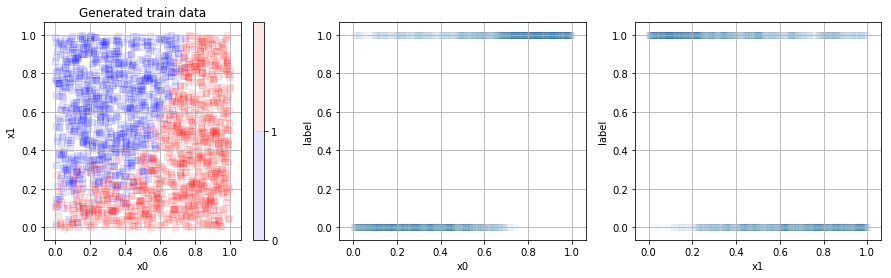

In [3]:
N = 2000
# x has 1 dim in R, label has 1 dim in B
xTrain, labelTrain = generateBatch(N)

colors = ['blue','red']

fig = plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(xTrain[:,0], xTrain[:,1], c=labelTrain, cmap=pltcolors.ListedColormap(colors), marker=',', alpha=0.1)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Generated train data')
plt.grid()
cb = plt.colorbar()
loc = np.arange(0,1,1/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([0,1])
plt.subplot(1,3,2)
plt.scatter(xTrain[:,0], labelTrain, marker=',', alpha=0.01)
plt.xlabel('x0')
plt.ylabel('label')
plt.grid()
plt.subplot(1,3,3)
plt.scatter(xTrain[:,1], labelTrain, marker=',', alpha=0.01)
plt.xlabel('x1')
plt.ylabel('label')
plt.grid()

Bernouilli parameter of the distribution: 0.5125


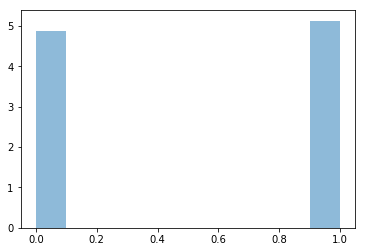

In [4]:
count, bins, ignored = plt.hist(labelTrain*1.0, 10, density=True, alpha=0.5)
p = np.mean(labelTrain)
print('Bernouilli parameter of the distribution:', p)

### Test data for verification of the model

In [5]:
xTest, labelTest = generateBatch(N)
testColors = ['navy', 'orangered']

### Logistic and log of Logistic functions

The Logistic function is used to transform a linear separation of the plan into a probability in the range \[0,1\]

\begin{align}
 logistic(x) = \frac{1}{1+e^{-x}}
\end{align}

In [6]:
def logistic(X):
    return (1+(np.exp(-(X))))**-1

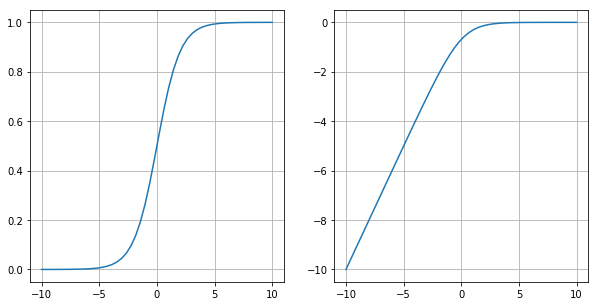

In [7]:
xx = np.linspace(-10, 10)
xlogistic = logistic(xx)
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(xx, xlogistic)
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(xx, np.log(xlogistic))
plt.grid()

# Logistic regression

\begin{align}
y \in \left\{ 0, 1 \right\}
\end{align}

\begin{align}
p (Y=1 \mid x) & = \frac{1}{1+e^{-f(x)}} \\
p (Y=0 \mid x) & = 1 - \frac{1}{1+e^{-f_\theta(x)}} \\
f_\theta(x) & = b + w x 
\end{align}

Let's define $\theta=\{b, w\}$

We are looking for the value of $\theta$ that maximizes the likelyhood:
\begin{align}
\hat{\theta} & = \max_{w}{\prod_{i=0}^N{p(y_i \mid  x_i, \theta)}} \\
& = \max_{\theta}{\sum_{i=0}^N{log \bigl(p(y_i \mid x_i, \theta)\bigr)} } \\
& = \max_{\theta}{\sum_{i=0}^N{log \biggl(\bigl(\frac{1}{1+e^{-f_\theta(x_i)}}\bigr)^{y_i}\bigl(1-\frac{1}{1+e^{-f_\theta(x_i)}}\bigr)^{1-y_i}\biggr)} } \\
& = \max_{\theta}{\sum_{i=0}^N{log \biggl(y_i * \bigl(\frac{1}{1+e^{-f_\theta(x_i)}}\bigr) + \bigl(1-y_i\bigr) * \bigl(1-\frac{1}{1+e^{-f_\theta(x_i)}}\bigr) \biggr)} } \\
\end{align}

Using the fact that $y_i$ is either 0 or 1

If using an iterative algorithm, the cost function to minimize is taken as the negative maximum log likelyhood:
\begin{align}
J{_\theta} & = - \sum_{i=0}^N{log \biggl(y_i * \bigl(\frac{1}{1+e^{-f_\theta(x_i)}}\bigr) + \bigl(1-y_i\bigr) * \bigl(1-\frac{1}{1+e^{-f_\theta(x_i)}}\bigr) \biggr)} \\
\end{align}

Reference:
- https://en.wikipedia.org/wiki/Logistic_regression


## Homemade fitting of $b$ and then $w$


Suboptimal fitting:
- Taking some assumption on $w$ to fit $b$ as $\hat{b}$
- and then fitting $w$ with the $\hat{b}$ estimate using a simple grid search

Estimated b = 0.408163265306122


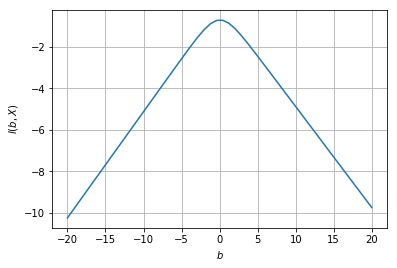

In [8]:
bs = np.linspace(-20, 20)
ws = np.array([0,0]);
px = np.zeros(len(bs))
for i in range(len(bs)):
    fx = logistic(bs[i] + np.matmul(xTrain, ws))
    px[i] = 1/N * np.sum(np.log(labelTrain * fx + (1 - labelTrain)*(1 - fx)))
plt.plot(bs, px);
plt.xlabel('$b$')
plt.ylabel('$l(b, X)$')
plt.grid()
bHat = bs[np.argmax(px)]
print('Estimated b =', bHat) 

### Fitting $w$ with a simple grid search 

In [9]:
w0 = np.linspace(-20, 20)
w1 = np.linspace(-20, 20)
px = np.zeros((len(w0), len(w1)))
for i in range(len(w0)):
    for j in range(len(w1)):
        fx = logistic(bHat + np.matmul(xTrain, np.array([w0[i], w1[j]])))
        px[i, j] = 1/N * np.sum(np.log(np.multiply(labelTrain, fx) + np.multiply((1-labelTrain),(1-fx))))
m = np.argmax(px)
wHat = np.array([w0[m//len(w0)], w1[m%len(w0)]])
print('Estimated w =', wHat)

Estimated w = [ 11.02040816 -11.02040816]


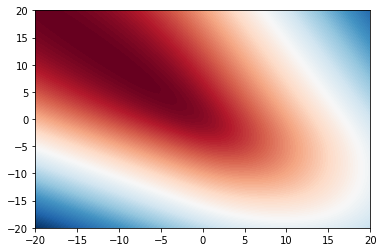

In [10]:
plt.contourf(w0,w1,px, levels=128, cmap="RdBu_r");

## Testing of model 0 (homemade)

In [11]:
yEst0 = logistic(bHat + np.matmul(xTest, wHat))
labelEst0 = yEst0 > 0.5

In [12]:
labelEst0.shape

(2000,)

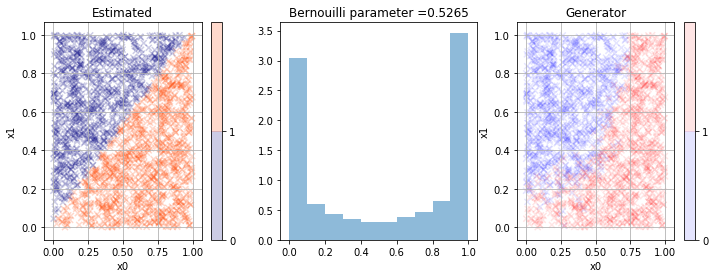

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(xTest[:,0], xTest[:,1], c=labelEst0, cmap=pltcolors.ListedColormap(testColors), marker='x', alpha=0.2);
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.title('Estimated')
cb = plt.colorbar()
loc = np.arange(0,1,1./len(testColors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1]);
plt.subplot(1,3,2)
plt.hist(yEst0, 10, density=True, alpha=0.5)
plt.title('Bernouilli parameter =' + str(np.mean(labelEst0)))
plt.subplot(1,3,3)
plt.scatter(xTest[:,0], xTest[:,1], c=labelTest, cmap=pltcolors.ListedColormap(colors), marker='x', alpha=0.1);
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.title('Generator')
cb = plt.colorbar()
loc = np.arange(0,1,1./len(colors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1]);

In [14]:
accuracy0 = np.sum(labelTest == labelEst0)/N
print('Accuracy =', accuracy0)

Accuracy = 0.8825


### Precision 
$p(y = 1 \mid \hat{y} = 1)$

In [15]:
print('Precision =', np.sum(labelTest[labelEst0 == 1])/np.sum(labelEst0))

Precision = 0.8727445394112061


### Recall
$p(\hat{y} = 1 \mid y = 1)$

In [16]:
print('Recall =', np.sum(labelTest[labelEst0 == 1])/np.sum(labelTest))

Recall = 0.9009803921568628


### Confusion matrix

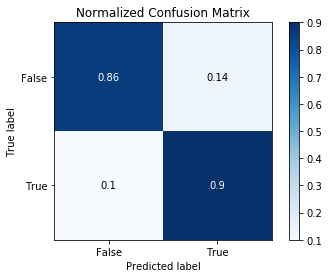

In [17]:
skplt.metrics.plot_confusion_matrix(labelTest, labelEst0, normalize=True);

In [18]:
print(skMetrics.classification_report(labelTest, labelEst0))

              precision    recall  f1-score   support

       False       0.89      0.86      0.88       980
        True       0.87      0.90      0.89      1020

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



# Using SciKit Learn's linear regression

References:
- SciKit documentation
- https://www.geeksforgeeks.org/ml-logistic-regression-using-python/

In [19]:
model1 = SkLinReg(solver='lbfgs')
model1.fit(xTrain, labelTrain)
print('Y = logistic({0} X + {1})'.format(model1.coef_, model1.intercept_))

Y = logistic([[ 9.3660484  -7.11483695]] X + [-0.99185981])


In [20]:
labelEst1 = model1.predict(xTest)
print('Score (R^2) =', model1.score(xTest, labelTest))

Score (R^2) = 0.902


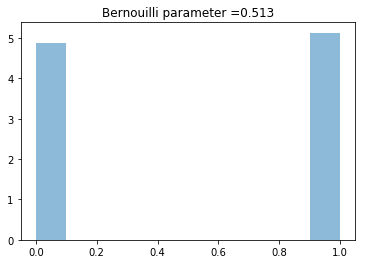

In [21]:
plt.hist(labelEst1*1.0, 10, density=True, alpha=0.5)
plt.title('Bernouilli parameter =' + str(np.mean(labelEst1)));

### Confusion matrix (plot)

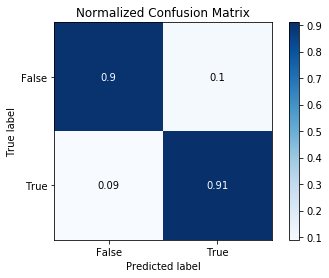

In [22]:
#skMetrics.confusion_matrix(labelTest, labelEst1)
skplt.metrics.plot_confusion_matrix(labelTest, labelEst1, normalize=True);

### Classification report

In [23]:
print(skMetrics.classification_report(labelTest, labelEst1))

              precision    recall  f1-score   support

       False       0.90      0.90      0.90       980
        True       0.90      0.91      0.90      1020

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



References :
- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.get_params

### ROC curve

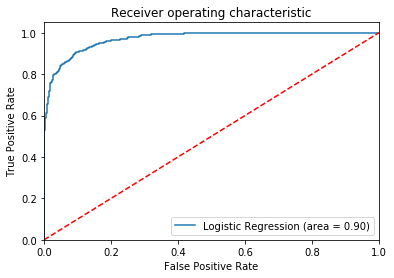

In [24]:
logit_roc_auc = skMetrics.roc_auc_score(labelTest, labelEst1)
fpr, tpr, thresholds = skMetrics.roc_curve(labelTest, model1.predict_proba(xTest)[:,1])
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right");

# Using SciKitLearn's gradient descent classifier

References:
- https://scikit-learn.org/stable/modules/sgd.html#classification

In [25]:
from sklearn.linear_model import SGDClassifier as skSGDClassifier

model2 = skSGDClassifier(alpha=0.0001, average=False, class_weight=None,
           early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
           l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
           n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
           random_state=None, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

Notes:
- Regularizer is called 'penalty' and parameterized by 'alpha' (and 'l1_ratio')
- Early stopping is available and parameterized by 'early_stopping', 'max_iter', 'tol' and 'n_iter_no_change'
- Shuffling between epochs enabled by 'shuffle'

In [26]:
model2.fit(xTrain, labelTrain);
print('Y = logistic({0} X + {1})'.format(model2.coef_, model2.intercept_))

Y = logistic([[ 13.25147177 -10.8221533 ]] X + [-1.71877966])


In [27]:
labelEst2 = model2.predict(xTest)
print('Score (R^2) =', model2.score(xTest, labelTest))

Score (R^2) = 0.8915


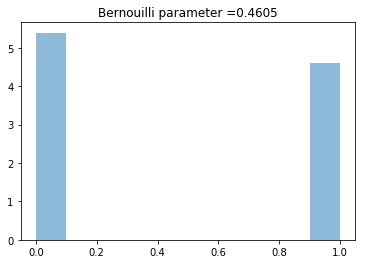

In [28]:
plt.hist(labelEst2*1.0, 10, density=True, alpha=0.5)
plt.title('Bernouilli parameter =' + str(np.mean(labelEst2)));

### Confusion matrix (plot)

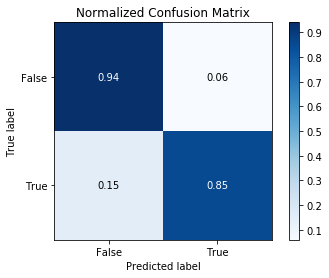

In [29]:
skplt.metrics.plot_confusion_matrix(labelTest, labelEst2, normalize=True);

### Classification report

In [30]:
print(skMetrics.classification_report(labelTest, labelEst2))

              precision    recall  f1-score   support

       False       0.85      0.94      0.89       980
        True       0.94      0.85      0.89      1020

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.90      0.89      0.89      2000



# Where to go from here ?

__Other linear implementations and simple neural nets__ [using TensorFlow](ClassificationContinuous2Features-TensorFlow.html) ([Notebook](ClassificationContinuous2Features-TensorFlow.ipynb)), [using Keras](ClassificationContinuous2Features-Keras.html) ([Notebook](ClassificationContinuous2Features-Keras.ipynb)) or the [__K Nearest Neighbors classifier__](ClassificationContinuous2Features-KNN.html) ([Notebook](ClassificationContinuous2Features-KNN.ipynb))

__More complex multi-class models__ on the Czech and Norways flags [using Keras](ClassificationMulti2Features-Keras.html) ([Notebook](ClassificationMulti2Features-Keras.ipynb)), showing one of the main motivations to neural networks.

__Compare with the two feature linear regression__ [using simple algorithms](../linear/LinearRegressionBivariate.html) ([Notebook](LinearRegressionBivariate.ipynb])), [or using Keras](LinearRegressionBivariate-Keras.html) ([Notebook](LinearRegressionUnivariate-Keras.ipynb))